<a href="https://colab.research.google.com/github/NataliaBilash/network_scanner/blob/master/edr_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Препроцессинг

Целью препроцессинга является первичная обработка данных, в результате которой должен получится массив содержащий обработанные значения в диапазоне от 0 до 1

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Чтобы масштабировать значения IP адреса в диапазон от 0 до 1 была создана функция scale_ip_addresses, получающая на вход IP адрес формата: доменное имя, ipv4 или ipv6, на выходе получается массив отмаштабированных значений. Получая ipv4 или ipv6 разбивает на октеты и делит на 255/65536, чтобы получились знеачения в нужном диапазоне.

In [ ]:
import ipaddress

def scale_ip_addresses(ip_address):
    try:
        ip_obj = ipaddress.ip_address(ip_address) #создает объект IP-адреса
        if ip_obj.version == 4:
            octets = ip_address.split('.')
            scaled_octets = [int(octet) / 255.0 for octet in octets]
            return scaled_octets
        elif ip_obj.version == 6:
            groups = ip_obj.exploded.split(':')
            decimal_values = [int(group, 16) for group in groups]
            scaled_values = [(value + 1) / 65536.0 for value in decimal_values]
            return scaled_values
        else:
            ip_address_domain = socket.gethostbyname(ip_address)
            octets = ip_address_domain.split('.')
            scaled_octets = [int(octet) / 255.0 for octet in octets]
            return scaled_octets
    except ValueError:
        return [0, 0, 0, 0]

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/normal.csv')
print('Input dataframe')
print(df)

#удаление ненужных столбцов
df = df.drop(columns = ['Info', 'No.'], axis=1)

#обработка пропущенных значений
df = df.replace("Missing", pd.NA)
df = df.replace("Offln", pd.NA)
df = df.dropna()

#создание столбцов вида "Название протокола" - наличие/отсутсвие 1/0
protocol_dummies = pd.get_dummies(df['Protocol'], prefix='Protocol')
protocol_dummies = protocol_dummies.astype(int)
df_encoded = pd.concat([df, protocol_dummies], axis=1)
df_encoded.drop(['Protocol'], axis=1, inplace=True)

#применение функции scale_ip_addresses
df_encoded['Source_scaled'] = df_encoded['Source'].apply(scale_ip_addresses)
df_encoded['Destination_scaled'] = df_encoded['Destination'].apply(scale_ip_addresses)

#дополнение ipv4 до длинны 8 октетов нулями и добаление столбцоы
df_encoded['Source_scaled'] = df_encoded['Source_scaled'].apply(lambda x: x + [0] * (8 - len(x)))
df_encoded['Destination_scaled'] = df_encoded['Destination_scaled'].apply(lambda x: x + [0] * (8 - len(x)))
source_octets_df = pd.DataFrame(df_encoded['Source_scaled'].tolist(), columns=[f'Source_Octet{i}' for i in range(1, 9)])
destination_octets_df = pd.DataFrame(df_encoded['Destination_scaled'].tolist(), columns=[f'Destination_Octet{i}' for i in range(1, 9)])

#соединение датафреймов и удаление ненужных столбцов
df_encoded = pd.concat([df_encoded, source_octets_df, destination_octets_df], axis=1)
df_encoded.drop(['Source_scaled', 'Destination_scaled', 'Source', 'Destination'], axis=1, inplace=True)
df_encoded.fillna(0, inplace=True)

#нормализует значения в столбце Length и Timing_data с использованием Min-Max Scaling
scaler = MinMaxScaler()
df_encoded[['Length']] = scaler.fit_transform(df_encoded[['Length']])
df_encoded[['Timing_data']] = scaler.fit_transform(df_encoded[['Time']])

print('Output dataframe')
print(df_encoded)
print('Shape dataframe')
print(df_encoded.shape)


Input dataframe
             No.           Time       Source  Destination    Protocol  Length  \
0              1       0.000000  185.175.0.3  185.175.0.5         TCP      66   
1              2       0.020652  185.175.0.3  185.175.0.5         TCP      74   
2              3       0.020690  185.175.0.5  185.175.0.3         TCP      74   
3              4       0.020714  185.175.0.3  185.175.0.5         TCP      66   
4              5       0.020828  185.175.0.3  185.175.0.5  Modbus/TCP      78   
...          ...            ...          ...          ...         ...     ...   
1164774  1164775  118343.565389  185.175.0.3  185.175.0.5         TCP      74   
1164775  1164776  118343.565429  185.175.0.5  185.175.0.3         TCP      74   
1164776  1164777  118343.565454  185.175.0.3  185.175.0.5         TCP      66   
1164777  1164778  118343.565899  185.175.0.3  185.175.0.5  Modbus/TCP      78   
1164778  1164779  118343.565913  185.175.0.5  185.175.0.3         TCP      66   

           

#### Разделение на тестовые и тренировачные выборки

In [ ]:
import numpy as np

split_index = int(len(df_encoded) * 0.8)  #80% для обучения

train = df_encoded.iloc[:split_index]
test = df_encoded.iloc[split_index:]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (931823, 23)
Test dataset shape: (232956, 23)


Повторная нормализация нужна, чтобы обеспечить одинаковую шкалу значений на обеих выборках.

In [ ]:
#нормализация данных
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
print("Normalize train dataset:")
print(X_train)
print("Normalize test dataset:")
print(X_test)

Normalize train dataset:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.18146860e-07 5.16129032e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.18146860e-07]
 [2.18548253e-07 5.16129032e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.18548253e-07]
 ...
 [9.99999999e-01 5.16129032e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.99999999e-01]
 [1.00000000e+00 5.16129032e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
Normalize test dataset:
[[1.         0.07741935 0.         ... 0.         0.         1.        ]
 [1.         0.         0.         ... 0.         0.         1.        ]
 [1.00000001 0.06451613 0.         ... 0.         0.         1.00000001]
 ...
 [1.25006184 0.         0.         ... 0.         0.         1.25006184]
 [1.25006185 0.07741935 0.         ... 0.         0.  

#### Изменить форму входных данных для LSTM

Изменить форму нужно, так как на вход LSTM принимается 3D-тензор с формой (batch, timesteps, feature), где
batch: количество пакетов в наборе данных,
timesteps: количество временных шагов в пакете,
features: количество признаков в каждом временном шаге.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (931823, 1, 23)
Test data shape: (232956, 1, 23)


## LSTM

Для модели LSTM создается начальный слой, где указывется количество временных щагов и количество признаков. Далее в кажом слое с нейронами есть функция dropout, которая помогает предотвратить переобучение, затушивая случайные нейроны в процессе обучения.

Слой RepeatVector нужен, чтобы данные восстанавливали то же измерение, что и исходные входные данные, то есть преобразование тензора функций из 1D в 2D так как для кодера-декодера входные данные сжимаются в один вектор признаков.

На выходном слое TimeDistributed применяет Dense к каждому пакету, который он получает в качестве входных данных.

In [ ]:
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(32, activation='relu', return_sequences=True, dropout=0.2)(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=False, dropout=0.2)(L1)
    #повторяет последний выходной вектор
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(16, activation='relu', return_sequences=True, dropout=0.2)(L3)
    L5 = LSTM(32, activation='relu', return_sequences=True, dropout=0.2)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

Далее создается модель автоэнкодера, экперементальным путем был выделен оптимизатор Adam с заданным коэффициентом скорости обучения 0,001
loss='mae' задает функцию потерь, MAE измеряет среднее абсолютное отклонение между фактическими и предсказанными значениями, также ослеживается
метрика accuracy

In [ ]:
from keras.optimizers import Adam

model = autoencoder_model(X_train)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mae', metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 23)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 32)             7168      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 16)             0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 1, 16)             2112      
                                                                 
 lstm_3 (LSTM)               (None, 1, 32)             6272      
                                                             

In [ ]:
from keras.callbacks import ModelCheckpoint

X_val = X_test
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)
history1 = model.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_val, X_val), callbacks=[checkpoint])



Epoch 1/50
14560/14560 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.1825
Epoch 1: val_loss improved from inf to 0.05209, saving model to best_model.h5
14560/14560 [==============================] - 244s 16ms/step - loss: 0.0331 - accuracy: 0.1825 - val_loss: 0.0521 - val_accuracy: 0.0000e+00
Epoch 2/50
   10/14560 [..............................] - ETA: 2:59 - loss: 0.0338 - accuracy: 0.2812

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14560/14560 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.1923
Epoch 2: val_loss did not improve from 0.05209
14560/14560 [==============================] - 247s 17ms/step - loss: 0.0292 - accuracy: 0.1923 - val_loss: 0.0532 - val_accuracy: 0.0000e+00
Epoch 3/50
14558/14560 [============================>.] - ETA: 0s - loss: 0.0287 - accuracy: 0.1827
Epoch 3: val_loss did not improve from 0.05209
14560/14560 [==============================] - 235s 16ms/step - loss: 0.0287 - accuracy: 0.1827 - val_loss: 0.0539 - val_accuracy: 0.0000e+00
Epoch 4/50
14559/14560 [============================>.] - ETA: 0s - loss: 0.0285 - accuracy: 0.1878
Epoch 4: val_loss did not improve from 0.05209
14560/14560 [==============================] - 236s 16ms/step - loss: 0.0285 - accuracy: 0.1878 - val_loss: 0.0551 - val_accuracy: 0.0000e+00
Epoch 5/50
14558/14560 [============================>.] - ETA: 0s - loss: 0.0283 - accuracy: 0.1813
Epoch 5: val_loss did not improve from 0.052

In [ ]:
from tensorflow.keras.models import load_model

LTSV_model = load_model('/content/drive/MyDrive/model_2.h5')
pred = LTSV_model.predict(X_test)


7280/7280 [==============================] - 19s 3ms/step


In [ ]:
X_test

array([[[1.        , 0.07741935, 0.        , ..., 0.        ,
         0.        , 1.        ]],

       [[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 1.        ]],

       [[1.00000001, 0.06451613, 0.        , ..., 0.        ,
         0.        , 1.00000001]],

       ...,

       [[1.25006184, 0.        , 0.        , ..., 0.        ,
         0.        , 1.25006184]],

       [[1.25006185, 0.07741935, 0.        , ..., 0.        ,
         0.        , 1.25006185]],

       [[1.25006185, 0.        , 0.        , ..., 0.        ,
         0.        , 1.25006185]]])

In [ ]:
pred

array([[[ 7.29458749e-01,  6.92845497e-04,  1.77562470e-04, ...,
         -1.01656653e-04, -3.09515744e-05,  7.29291320e-01]],

       [[ 7.26959229e-01,  6.90801477e-04,  1.80259813e-04, ...,
         -1.04529783e-04, -3.05026770e-05,  7.26790369e-01]],

       [[ 7.29678214e-01,  6.93019363e-04,  1.77423237e-04, ...,
         -1.01567246e-04, -3.09254974e-05,  7.29510427e-01]],

       ...,

       [[ 9.05444860e-01,  8.70910415e-04,  7.22792465e-05, ...,
          1.41618773e-04,  3.56417149e-05,  9.05944169e-01]],

       [[ 9.07569289e-01,  8.81076674e-04,  7.37123191e-05, ...,
          1.29595399e-04,  4.28725034e-05,  9.08095002e-01]],

       [[ 9.05662179e-01,  8.69720476e-04,  7.30557367e-05, ...,
          1.41282566e-04,  3.65339220e-05,  9.06161249e-01]]],
      dtype=float32)

## Результаты
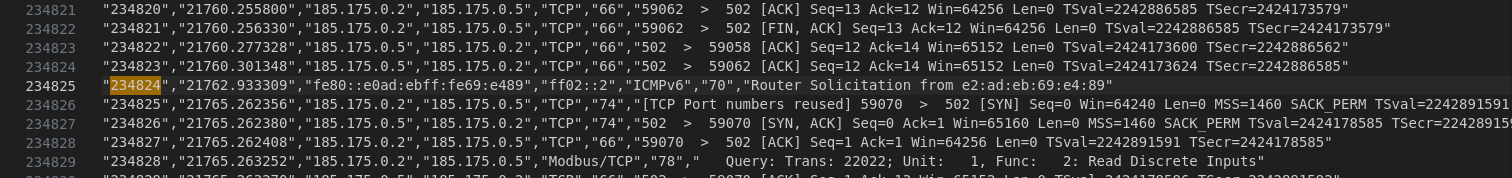

Выполняет оценку MAE между фактическими данными (X_test_reshaped) и предсказанными данными (pred_reshaped). Среднее абсолютное отклонение на каждом временном шаге и для каждого признака = ранее выбрано моделью на этапе обучения, как оптимальное val_loss.

In [ ]:
from sklearn.metrics import mean_absolute_error

#Для оценки нужно перевети в двухмерный массив
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
pred_reshaped = pred.reshape(-1, pred.shape[2])

mae = mean_absolute_error(X_test_reshaped, pred_reshaped)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.05209313675194556


# Тесты на данных с аномалиями

Для поиска оценки обработки аномалий были проведены следующие эксперементы. В качестстве датасета с аномалиями был применен массив данных с специально изменеными данными, сильно отличающимися от нормлаьных

In [ ]:
df_anomaly_test = pd.read_csv('/content/drive/MyDrive/attack3.csv')

df_anomaly_test = df_anomaly_test.drop(columns = ['Info', 'No.'], axis=1)
df_anomaly_test = df_anomaly_test.replace("Missing", pd.NA)
df_anomaly_test = df_anomaly_test.replace("Offln", pd.NA)
df_anomaly_test = df_anomaly_test.dropna()

protocol_dummies = pd.get_dummies(df_anomaly_test['Protocol'], prefix='Protocol')
protocol_dummies = protocol_dummies.astype(int)

df_anomaly_test_encoded = pd.concat([df_anomaly_test, protocol_dummies], axis=1)
df_anomaly_test_encoded.drop(['Protocol'], axis=1, inplace=True)

df_anomaly_test_encoded['Source_scaled'] = df_anomaly_test_encoded['Source'].apply(scale_ip_addresses)
df_anomaly_test_encoded['Destination_scaled'] = df_anomaly_test_encoded['Destination'].apply(scale_ip_addresses)
df_anomaly_test_encoded['Source_scaled'] = df_anomaly_test_encoded['Source_scaled'].apply(lambda x: x + [0] * (8 - len(x)))
df_anomaly_test_encoded['Destination_scaled'] = df_anomaly_test_encoded['Destination_scaled'].apply(lambda x: x + [0] * (8 - len(x)))

source_octets_df_anomaly_test = pd.DataFrame(df_anomaly_test_encoded['Source_scaled'].tolist(), columns=[f'Source_Octet{i}' for i in range(1, 9)])
destination_octets_df_anomaly_test = pd.DataFrame(df_anomaly_test_encoded['Destination_scaled'].tolist(), columns=[f'Destination_Octet{i}' for i in range(1, 9)])


df_anomaly_test_encoded = pd.concat([df_anomaly_test_encoded, source_octets_df_anomaly_test, destination_octets_df_anomaly_test], axis=1)
df_anomaly_test_encoded.drop(['Source_scaled', 'Destination_scaled', 'Source', 'Destination'], axis=1, inplace=True)
df_anomaly_test_encoded.fillna(0, inplace=True)

scaler1 = MinMaxScaler()
df_anomaly_test_encoded[['Length']] = scaler.fit_transform(df_anomaly_test_encoded[['Length']])
df_anomaly_test_encoded[['Timing_data']] = scaler.fit_transform(df_anomaly_test_encoded[['Time']])

#нормализация данных
scaler2 = MinMaxScaler()
df_anomaly_test_scaled = scaler.fit_transform(df_anomaly_test_encoded)
print("Normalize dataset:")
print(df_anomaly_test_scaled)

df_anomaly_test_shaped = df_anomaly_test_scaled.reshape(df_anomaly_test_scaled.shape[0], 1, df_anomaly_test_scaled.shape[1])
print("Data shape:", df_anomaly_test_shaped.shape)

Normalize dataset:
[[0.00000000e+00 9.16030534e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.01143859e-10 4.58015267e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.01143859e-10]
 [2.06885165e-09 8.77862595e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.06885165e-09]
 ...
 [9.99999809e-01 4.58015267e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.99999809e-01]
 [1.00000000e+00 7.63358779e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 7.63358779e-02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
Data shape: (1178259, 1, 23)


In [ ]:
LTSV_model = load_model('/content/drive/MyDrive/model_2.h5')
pred_anomaly_test = LTSV_model.predict(df_anomaly_test_shaped)

36821/36821 [==============================] - 96s 3ms/step


## 1 метод

Нахождение аномалий происходит через прохождение порога при вычислении среднеквадратичной ошибки (MSE) между X_test и pred. Порог был поставлен для примера

In [ ]:
def mse(df_anomaly_test_shaped, pred_anomaly_test):
 df_anomaly_test_shaped, pred_anomaly_test = np.array(df_anomaly_test_shaped), np.array(pred_anomaly_test)
 return np.square(np.subtract(df_anomaly_test_shaped, pred_anomaly_test)).mean()

mse=mse(df_anomaly_test_shaped, pred_anomaly_test)
threshold = 0.001
anomalies = df_anomaly_test_shaped[mse > threshold]
print(mse)

0.022410756769373354


In [ ]:
print(anomalies) # как видно на резульат выводится полный маасив данных

[[[[0.00000000e+00 9.16030534e-02 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]]

  [[1.01143859e-10 4.58015267e-02 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 1.01143859e-10]]

  [[2.06885165e-09 8.77862595e-02 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 2.06885165e-09]]

  ...

  [[9.99999809e-01 4.58015267e-02 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 9.99999809e-01]]

  [[1.00000000e+00 7.63358779e-02 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 1.00000000e+00]]

  [[1.00000000e+00 7.63358779e-02 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 1.00000000e+00]]]]


Была произведена попытка построить гисторграмму и вычислить выбросы, и в теории можно вычислить наиболее отличающиеся значения и посчитать их аномалиями.

In [ ]:
anomalies = anomalies.reshape(-1, anomalies.shape[2])
print(anomalies.shape)

(27099957, 1)


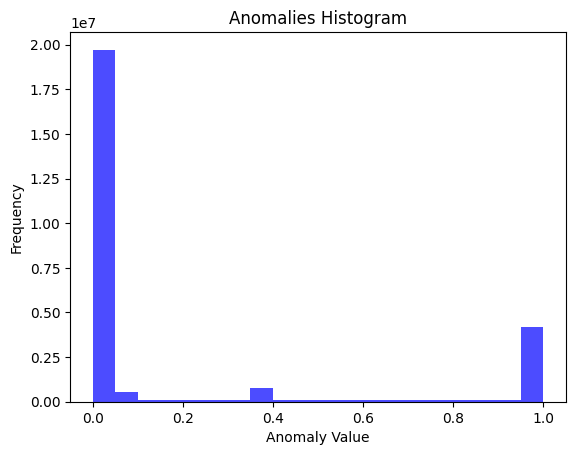

In [ ]:
import matplotlib.pyplot as plt
anomalies_values = [item[0] for item in anomalies]

#гистограмма
plt.hist(anomalies_values, bins=20, color='blue', alpha=0.7)
plt.title('Anomalies Histogram')
plt.xlabel('Anomaly Value')
plt.ylabel('Frequency')
plt.show()

## 2 Метод (Z-оценки)

Сменим подход и теперь будем вычислять разницу между предсказаными и тестовыми значениями, затем с помощью среднего значения, и вычисления z-оценок для каждого элемента подмассива найдем аномалии, тое сть наиболее отличающиеся разницы массивов X_test и diff

In [ ]:
df_anomaly_test_reshaped = df_anomaly_test_shaped.reshape(-1, df_anomaly_test_shaped.shape[2])
pred_anomaly_test_reshaped = pred_anomaly_test.reshape(-1, pred_anomaly_test.shape[2])

diff = np.abs(df_anomaly_test_reshaped - pred_anomaly_test_reshaped)
diff.shape

(1178259, 23)

In [ ]:
mean_value = sum(diff) / len(diff)

print(f"Среднее значение: {mean_value}")

Среднее значение: [1.39476955e-01 5.64272782e-02 1.30726280e-04 3.65668509e-04
 1.82044359e-01 1.82488632e-01 2.55290963e-04 5.09639204e-04
 2.97125652e-04 2.91247335e-01 1.40054360e-04 2.17792900e-04
 2.11553903e-04 2.78176494e-04 4.23566652e-04 6.51210232e-04
 3.90101644e-04 5.56112712e-03 3.66794453e-04 7.64768644e-04
 2.32749349e-04 2.56325070e-04 1.39555352e-01]


In [ ]:
#Z-оценки для каждого элемента каждого подмассива
z_scores = (diff - mean_value) / np.std(diff, axis=0)

#сумма абсолютных Z-оценок для каждого подмассива
sum_z_scores = np.sum(np.abs(z_scores), axis=1)

#нахождение наиболее отличающихся, можно настроить вывод, в данном случае топ 5 отличающихся
top_indices = np.argsort(sum_z_scores)[-1000:]
# for index in top_indices:
#     print(f"Отличающийся подмассив {index + 1}: {diff[index]}")

In [ ]:
selected_rows = df_anomaly_test.loc[top_indices]
condition = selected_rows['Source'] != 'fe80::e0ad:ebff:fe69:e489'
condition2 = selected_rows['Source'] != 'fe80::42:f9ff:fe49:f009'
filtered_df = selected_rows[condition]
filtered_df = filtered_df[condition2]

# Выведем результат
print(filtered_df)

                  Time       Source  Destination    Protocol  Length
97303      9023.751093  185.175.0.5  185.175.0.2  Modbus/TCP      77
78138      7248.432879  185.175.0.5  185.175.0.2  Modbus/TCP      78
85865      7957.479209  185.175.0.5  185.175.0.2  Modbus/TCP      77
85875      7957.503464  185.175.0.5  185.175.0.2  Modbus/TCP      77
90345      8370.587151  185.175.0.2  185.175.0.5  Modbus/TCP      78
...                ...          ...          ...         ...     ...
1043138   96400.966958  185.175.0.1  224.0.0.251        MDNS     160
107933    10000.657092  185.175.0.1  224.0.0.251        MDNS     160
1082051  100000.975184  185.175.0.1  224.0.0.251        MDNS     160
1120615  103600.986175  185.175.0.1  224.0.0.251        MDNS     160
1160245  107200.994154  185.175.0.1  224.0.0.251        MDNS     160

[789 rows x 5 columns]


<ipython-input-45-90f45eaac410>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[condition2]
